<a href="https://colab.research.google.com/github/Zocha1/Introduction-To-Machine-Learning/blob/main/6_PRZYK%C5%81AD_Przetwarzanie_obraz%C3%B3w.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Przykładowa sieć konwolucyjna
Zbudowany model ma za zadanie odróżniać psa od kota na zdjęciach.

##Etap 1 Budowanie modelu


Tworzymy model **sekwencyjny**. Oznacza to że, że model będzie składał się z sekwencji warstw, gdzie dane wejściowe przechodzą przez nie jedna po drugiej.

Dodajemy warstwę **konwolucyjną**, która jest podstawą sieci konwolucyjnej. Ta warstwa przetwarza dane wejściowe (obrazy) za pomocą **32 filtrów** (lub "jąder") o rozmiarze 3x3 piksele. activation="relu" oznacza **funkcję aktywacji ReLU**, która przekształca wartości ujemne na zero, a pozytywne pozostawia bez zmian. padding='same' oznacza, że na brzegach obrazu dodajemy padding (dopełnienie), aby rozmiar wyjścia był taki sam jak wejścia. input_shape=(100,100,3) określa kształt danych wejściowych: obrazy o rozmiarze 100x100 pikseli i 3 kanałach kolorów (RGB).

Dodajemy warstwę **normalizacji wsadowej**, która normalizuje wyjście poprzedniej warstwy. Pomaga to w przyspieszeniu treningu i stabilizacji procesu uczenia się poprzez utrzymanie wartości wyjściowych warstw w małych zakresach.

Dodajemy warstwę **Max Pooling** z oknem o rozmiarze 2x2 piksele, która redukuje wymiary danych przestrzennych, biorąc maksimum z każdego okna 2x2. Działa to na zasadzie przestrzennego próbkowania, zmniejszając liczbę parametrów i pomagając w zapobieganiu nadmiernemu dopasowaniu.

Dodajemy kolejną warstwę konwolucyjną z 64 filtrami, która będzie uczyć się bardziej skomplikowanych cech z danych, które zostały przekształcone przez poprzednie warstwy.

Ponawiamy dodanie warstwy normalizacji wsadowej oraz Max Pooling, tak jak wyżej.

I znów, dodajemy kolejne warstwy konwolucyjne, normalizacji wsadowej i Max Pooling, ale tym razem z 128 filtrami, co pozwala modelowi uczyć się jeszcze bardziej złożonych cech.

Powtarzamy proces, tym razem z 256 filtrami, co jest kontynuacją budowania hierarchii coraz bardziej złożonych cech.

Zamiast spłaszczać wszystkie mapy cech do jednego długiego wektora (co robi typowa warstwa Flatten), warstwa **GlobalAveragePooling2D** bierze średnią z każdej mapy cech, redukując w ten sposób liczbę parametrów i pomagając w zapobieganiu nadmiernemu dopasowaniu.

Dodajemy warstwę **Dropout** z prawdopodobieństwem 0.5, co oznacza, że w czasie treningu losowo "wyłączamy" połowę neuronów, co pomaga również w zapobieganiu nadmiernemu dopasowaniu.

Dodajemy w pełni połączoną **Dense** warstwę z 128 neuronami, co pozwala sieci na nauczenie się zależności między cechami wyekstrahowanymi przez warstwy konwolucyjne.

Dodajemy ostateczną w pełni połączoną warstwę z **2 neuronami** (jeden dla każdej klasy: koty i psy) i funkcją aktywacji softmax, która przypisuje prawdopodobieństwa do każdej z klas, umożliwiając klasyfikację.

Na koniec wywołujemy funkcję summary na modelu, która wypisuje podsumowanie architektury modelu, wyświetlając każdą warstwę, jej wyjście i liczbę parametrów.

In [15]:
#@title Building the model
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

train_path = '/content/trening'

test_path =  '/content/testy'

model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", padding='same', input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3, 3), activation="relu", padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3, 3), activation="relu", padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(256, (3, 3), activation="relu", padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dense(2, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 100, 100, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 50, 50, 64)        256       
 chNormalization)                                                
                                                        

##Podział danych na treningowe i testowe (opcjonalne)


Tutaj został napisany skrypt dzielący gotowy dataset pobrany ze strony [Kaggle](https://www.kaggle.com/competitions/dogs-vs-cats) na foldery zaweierające dane do trenowania i do testowania. Jest to krok, którego my nie będziemy wykonywać, ponieważ zestaw MNIST jest już podzielony na te kategorie.

In [ ]:
#@title Dividing files to train and tests
import os
import shutil
from sklearn.model_selection import train_test_split

# Załóżmy, że wszystkie twoje obrazy są w tym folderze
all_images_dir = '/content/train/train'

# Twój docelowy folder treningowy i testowy
train_dir = '/content/trening'
test_dir = '/content/testy'

# Stwórz listy plików dla każdej klasy
cat_files = [os.path.join(all_images_dir, f) for f in os.listdir(all_images_dir) if f.startswith('cat')]
dog_files = [os.path.join(all_images_dir, f) for f in os.listdir(all_images_dir) if f.startswith('dog')]

# Podziel dane na treningowe i testowe
train_cats, test_cats = train_test_split(cat_files, test_size=0.2)
train_dogs, test_dogs = train_test_split(dog_files, test_size=0.2)

# Funkcja do kopiowania plików
def copy_files(files, dest_dir):
    os.makedirs(dest_dir, exist_ok=True)
    for f in files:
        shutil.copy(f, dest_dir)

# Kopiowanie plików kotów
copy_files(train_cats, os.path.join(train_dir, 'cats'))
copy_files(test_cats, os.path.join(test_dir, 'cats'))

# Kopiowanie plików psów
copy_files(train_dogs, os.path.join(train_dir, 'dogs'))
copy_files(test_dogs, os.path.join(test_dir, 'dogs'))

print(f"Copied {len(train_cats)} cat images to training data.")
print(f"Copied {len(test_cats)} cat images to testing data.")
print(f"Copied {len(train_dogs)} dog images to training data.")
print(f"Copied {len(test_dogs)} dog images to testing data.")



Copied 10000 cat images to training data.
Copied 2500 cat images to testing data.
Copied 10000 dog images to training data.
Copied 2500 dog images to testing data.


##Etap 2 Kompilacja modelu

**Kompilacja** oznacza, że przygotowujemy model do treningu, określając kluczowe aspekty procesu uczenia się.

- **loss="categorical_crossentropy"**: to sposób, w jaki model mierzy, jak dobrze radzi sobie z zadaniem. "Categorical crossentropy" to funkcja straty używana w zadaniach klasyfikacji, gdzie model musi wybrać jedną z kilku kategorii (np. czy obraz przedstawia kota czy psa). Funkcja ta sprawdza, jak przewidywania modelu zgadzają się z rzeczywistymi etykietami i stara się je zminimalizować w trakcie treningu.

- **optimizer="Adam"**: to metoda, która modyfikuje wagi modelu w celu zminimalizowania funkcji straty. "Adam" jest popularnym optymalizatorem, ponieważ jest skuteczny w różnych sytuacjach i automatycznie dostosowuje prędkość uczenia się modelu.

- **metrics=["accuracy"]**: to kryteria, za pomocą których będziemy oceniać wydajność modelu. W tym przypadku używamy "dokładności", czyli procentu poprawnie sklasyfikowanych obrazów, aby zrozumieć, jak często model jest dokładny w swoich przewidywaniach.








In [16]:
#@title Compiling the model
model.compile(loss="categorical_crossentropy", optimizer = "Adam", metrics = ["accuracy"])

##Etap 3 Przygotowanie danych



Ten fragment kodu przygotowuje dane do procesu uczenia.
Składa się to z następujących kroków:

**1. Augmentacja danych**

**ImageDataGenerator** to narzędzie, które przygotowuje i przekształca dane (obrazy), aby zwiększyć różnorodność dostępnych przykładów treningowych poprzez ich modyfikację.

Augmentacje włączają:

- **rescale = 1./255** - normalizacja wartości pikseli obrazu z zakresu 0-255 do 0-1, co ułatwia przetwarzanie danych przez model.
- **rotation_range=25** - obraca obrazy o losowy kąt w zakresie do 25 stopni, aby model nauczył się rozpoznawać obiekty bez względu na ich orientację.
- **width_shift_range=0.1, height_shift_range=0.1** - przesuwa obrazy w poziomie i pionie o 10% ich szerokości lub wysokości, co pomaga modelowi nauczyć się, gdzie obiekt może się znajdować na obrazie.
- **shear_range=0.2** - stosuje fałszywe pochylenie obrazu, co symuluje różne perspektywy obserwacji obiektu.
- **zoom_range=0.2** - losowo powiększa część obrazu, ucząc model rozpoznawania obiektów na różnych poziomach zbliżenia.
- **horizontal_flip=True** - odwraca obrazy w poziomie, co jest przydatne, gdy kierunek obiektu nie wpływa na jego klasę.
- **fill_mode='nearest'** - sposób wypełniania nowych pikseli, które mogą pojawić się po transformacji obrazu.

**2. Generatory danych**

**train_generator** i **test_generator** służą do ładowania obrazów z określonych ścieżek (train_path i test_path), przekształcając je do uniformatnego rozmiaru (100x100 pikseli) i formatu (RGB). Generatory te również definiują, jak obrazy będą grupowane w partie (po 32), co jest istotne przy przetwarzaniu większych ilości danych.

**3. Klasa obrazów**

**class_mode = "categorical"** oznacza, że obrazy są klasyfikowane do jednej z wielu kategorii, co jest typowe w zadaniach, gdzie model musi określić, do której z kilku możliwych klas należy dany obraz.

In [ ]:
#@title Preparing the dataset
train_datagen = ImageDataGenerator(rescale = 1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(100,100),
                                                    batch_size = 32,
                                                    color_mode= "rgb",
                                                    class_mode = "categorical")
test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(100,100),
                                                  batch_size = 32,
                                                  color_mode= "rgb",
                                                  class_mode = "categorical")

print(test_generator.labels)


Found 24070 images belonging to 2 classes.
Found 7276 images belonging to 2 classes.
[0 0 0 ... 1 1 1]


##Etap 4 Trenowanie modelu

**Trenowanie modelu** to proces, w którym algorytm uczenia maszynowego iteracyjnie dostosowuje swoje parametry, ucząc się rozpoznawać wzorce z dostarczonych danych.

**1. Wczesne zatrzymywanie**

**EarlyStopping** jest mechanizmem zapobiegającym nadmiernemu dopasowaniu. Ten mechanizm monitoruje zmiany w wynikach modelu na danych walidacyjnych (testowych).

- **monitor='val_loss'** - mówi, że należy monitorować wartość straty na danych walidacyjnych (loss na danych testowych). Strata mierzy, jak bardzo przewidywania modelu różnią się od faktycznych etykiet.
- **patience=2** - określa, ile epok bez poprawy wyników model może jeszcze przetrenować zanim zostanie zatrzymany.
- **restore_best_weights=True** - jeśli zostanie włączone wczesne zatrzymanie, to ta opcja zapewni, że model wróci do stanu, w którym osiągnął najlepsze wyniki na danych walidacyjnych.

**2. Trenowanie modelu**

**model.fit** to funkcja, która faktycznie trenuje model na danych.
- **x=train_generator** - określa generator danych treningowych jako źródło danych dla modelu. Generator ten automatycznie podaje dane do modelu w partiami.
- **steps_per_epoch=len(train_generator)** - mówi, ile partii danych treningowych model powinien przetworzyć w jednej epoce. W praktyce, jest to liczba wszystkich dostępnych próbek podzielona przez rozmiar partii.
- **epochs=20** - definiuje, ile razy model powinien przejść przez cały zbiór treningowy.
- **validation_data=test_generator** - wskazuje generator danych walidacyjnych (testowych), które są używane do oceny modelu po każdej epoce.
- **validation_steps=len(test_generator)** - określa, ile partii danych walidacyjnych należy przetworzyć podczas każdej oceny.
- **verbose=1** - ustawienie to kontroluje, jak wiele informacji o procesie treningu jest wyświetlane (1 oznacza, że podstawowe informacje o procesie treningu będą wyświetlane).







In [ ]:
#@title Training the model

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

hist = model.fit(x=train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    verbose=1)

model.save("Dogs-vs-Cats.keras")

Epoch 1/20
753/753 [==============================] - 883s 1s/step - loss: 0.6665 - accuracy: 0.6282 - val_loss: 0.7907 - val_accuracy: 0.6299
Epoch 2/20
753/753 [==============================] - 857s 1s/step - loss: 0.5508 - accuracy: 0.7179 - val_loss: 0.6960 - val_accuracy: 0.6461
Epoch 3/20
753/753 [==============================] - 867s 1s/step - loss: 0.4588 - accuracy: 0.7816 - val_loss: 0.4003 - val_accuracy: 0.8160
Epoch 4/20
753/753 [==============================] - 868s 1s/step - loss: 0.3931 - accuracy: 0.8213 - val_loss: 0.9250 - val_accuracy: 0.6252
Epoch 5/20
753/753 [==============================] - 857s 1s/step - loss: 0.3428 - accuracy: 0.8480 - val_loss: 0.5547 - val_accuracy: 0.6873
Epoch 6/20
753/753 [==============================] - 867s 1s/step - loss: 0.3095 - accuracy: 0.8649 - val_loss: 0.2494 - val_accuracy: 0.8916
Epoch 7/20
753/753 [==============================] - 882s 1s/step - loss: 0.2867 - accuracy: 0.8767 - val_loss: 0.2385 - val_accuracy: 0.8994

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
test_loss, test_acc

228/228 [==============================] - 69s 300ms/step - loss: 0.2361 - accuracy: 0.8997


(0.23614037036895752, 0.8996701240539551)

##Test modelu

In [1]:
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Path to the saved model
model_path = r'/content/Dogs-vs-Cats.keras'

# Loading the model
model = load_model(model_path)

# Function for predicting the image
def predict_image(image_path):
    # Loading the image and converting it to the correct format
    img = load_img(image_path, target_size=(100, 100))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Adding a batch dimension
    img_array /= 255.0  # Normalization to the range 0-1

    # Predicting the image class
    prediction = model.predict(img_array)

    # Returning the image class and the confidence percentage
    class_index = np.argmax(prediction, axis=1)
    confidence = np.max(prediction, axis=1) * 100  # Confidence percentage

    if class_index == 0:
        return 'Cat', confidence[0]
    else:
        return 'Dog', confidence[0]



1/1 [==============================] - 0s 278ms/step


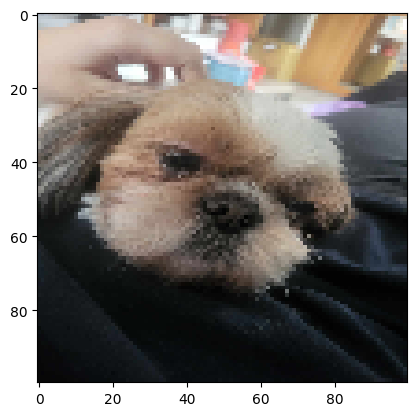

Predicted class for the image: Dog with confidence 80.04%


In [2]:
lila = r'/content/lila.jpg'
result, confidence = predict_image(lila)

img = load_img(lila, target_size=(100, 100))
img_array = img_to_array(img)
plt.imshow(img_array/255.0)
plt.show()

print(f"Predicted class for the image: {result} with confidence {confidence:.2f}%")


1/1 [==============================] - 0s 26ms/step


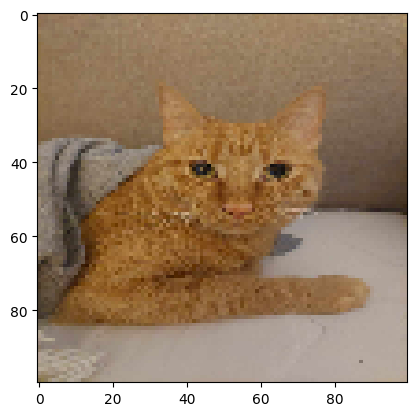

Predicted class for the image: Cat with confidence 98.46%


In [3]:
lapka = r'/content/łapka.jpg'
result, confidence = predict_image(lapka)

img = load_img(lapka, target_size=(100, 100))
img_array = img_to_array(img)
plt.imshow(img_array/255.0)
plt.show()

print(f"Predicted class for the image: {result} with confidence {confidence:.2f}%")